<a id="top"></a>
# Data Preparation and Modelling Experiments

## Contents

### 1. [Question Quality](#q_q)
### 2. [Answer Quality](#a_q)
### 3. [Tag Prediction](#t_p)

In [251]:
import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost

from nltk import word_tokenize
from gensim.models import word2vec

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    recall_score, precision_score, make_scorer)
from sklearn.metrics import plot_confusion_matrix

recall_scorer = make_scorer(recall_score)

import sklearn.metrics as metrics

def hamming_loss(multi_label_model_pipeline,train_x, train_y, test_x, test_y):
    predictions_test_y = multi_label_model_pipeline.predict(test_x)
    return metrics.hamming_loss(y_true=test_y, y_pred=predictions_test_y)

from time import time

import re

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook')

*********************
<a id="q_q"></a>
# 1. Question Quality
[Back to Top](#top) | [Next Section](#a_q)

In this section, I'm attempting to provide a model that can be implemented in a feature to alert users that they may need to take another look at their question, if it's likely to be 'low quality' (i.e. not receiving a response, or possible having a low score).

## 1.1 Vanilla vectorization

First, I'll deal with the Python Questions dataset:

https://www.kaggle.com/datasets/stackoverflow/pythonquestions

This will provide a large set of questions and answers for analysis and modelling, as well as providing some level of focus by only including Python questions.

I will attempt to predict the quality of questions by encoding the target as 1 or 0, based on number of answers/responses to that question (this is based on findings in EDA).

In [116]:
# Import dataset
q_all = pd.read_csv('../zippedData/Questions.csv', encoding='latin1')
a_all = pd.read_csv('../zippedData/Answers.csv', encoding='latin1')

In [117]:
def time_slice(data, y1=2008, m1=1, y2=2016, m2=12):
    """
    Function to select a range of questions (or answers) from the entire set.
    Start/end years and months work like indices, and thus a range
        from 2008-1 to 2009-3 would select all entries including 2008-1
        but excluding 2009-3, so always use an endpoint one month later
        than you want to include.
    
    Args:
    
    data : dataframe
    y1 : start year
    m1 : start month
    y2 : end year
    m2 : end month
    
    Returns:
    
    dataframe (with 'CreationDate' changed to datetime format)
    """
    df = data.copy()
    df['CreationDate']=pd.to_datetime(df['CreationDate'], infer_datetime_format=True)
    y1 = str(y1)
    y2 = str(y2)
    m1 = str(m1)
    m2 = str(m2)
    return df[(df.CreationDate >= (y1+'-'+m1)) & (df.CreationDate < (y2+'-'+m2))]

In [118]:
def q_prep1(data_q, data_a):
    """
    Function to prep the Questions dataframe (first stage)
    Returns dataframe with added feature:
        answer_count : # of answers the question received
        target : quality of the question
            0 : answer_count is >0
            1 : answer_count is 0 (no responses)
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target'] = df['answer_count'].map(lambda x: 0 if x > 0 else 1)
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target']]

In [119]:
# Select 6 months of data
a_1 = time_slice(a_all, 2015, 6, 2016, 1)
q_1 = time_slice(q_all, 2015, 6, 2016, 1)

In [120]:
# prep data
q_1 = q_prep1(q_1, a_1)

In [121]:
q_1.head()

,text,target
395542,Can you call Python from Excel in instances of...,0
395543,How to generate random points in a circular di...,0
395544,ndarray to series python <p>I have a ndarray l...,0
395545,Errors while using GUI function on OpenCV3 <p>...,0
395546,Python super override object name <p>I'm tryin...,0


In [122]:
q_2 = q_1.copy()

In [123]:
# function to collect a group of text cleaning strategies
def clean_text(text):
    # remove code
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    # remove html tags
    text = re.compile(r'<.*?>').sub(r'', text)
    # remove links
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    # remove linefeeds, non-letter/numbers, and whitespace
    text = re.sub(r'\n',' ', text)
    text = re.sub(r'\W', " ", text)
    text = re.sub(" +", " ", text)
    return text

In [124]:
q_2['text'] = q_2['text'].apply(clean_text)

In [125]:
# tokenize text
q_2_data = q_2['text'].map(word_tokenize).values

In [126]:
total_vocabulary = set(word for post in q_2_data for word in post)

print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 463100 unique tokens in the dataset.


In [127]:
q_2_target = list(q_2['target'])

In [128]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(q_2_data, q_2_target,\
                                                    test_size = 0.25, random_state = 42)

In [129]:
# create GLOVE dictionary for W2V
glove = {}
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [130]:
# boilerplate W2V vectorizer class
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required 
    # that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [145]:
# Creating pipelines for various models to test
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(max_iter=1000, ))])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost', xgboost.XGBClassifier())])

models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr), 
          ('XGBoost', xgb)]

In [25]:
scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean())\
          for name, model, in models]

scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[('Random Forest', 0.8284700924709713),
 ('Support Vector Machine', 0.8287820820310534),
 ('Logistic Regression', 0.8277475803978345),
 ('XGBoost', 0.8212614514210173)]

* These accuracy scores seem good, but let's investigate the confusion matrix:

In [146]:
from sklearn.metrics import ConfusionMatrixDisplay

def score_and_matrix(clf, X_test, X_train, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    tests = [('accuracy', accuracy_score), ('balanced accuracy', balanced_accuracy_score),\
            ('recall', recall_score), ('precision', precision_score)]
    for test, tester in tests:
        print(test,':',tester(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy : 0.8287192118226601
balanced accuracy : 0.500279096637643
recall : 0.0011524056467876692
precision : 0.2857142857142857


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


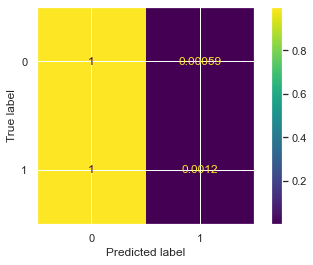

In [147]:
score_and_matrix(rf, X_test, X_train, y_train, y_test)

Unfortunately, we have a model that is just labelling everything as a 'good' post (target of 0). This may be due to class imbalance:

In [151]:
pd.Series(y_test).value_counts()

0    16829
1     3471
dtype: int64

### 1.1.1 W/ Metadata

Let's now try to incorporate metadata (time of posting) into the dataset and see if that impacts performance.

In [28]:
a_3 = time_slice(a_all, 2015, 6, 2016, 1)
q_3 = time_slice(q_all, 2015, 6, 2016, 1)

In [11]:
def q_prep2(data_q, data_a):
    """
    Second iteration of prep function.
    This is similar to the earlier function, now with added metadata:
        year
        month
        dayofweek
        hour
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target'] = df['answer_count'].map(lambda x: 0 if x > 0 else 1)
    
    df['year'] = q_3['CreationDate'].map(lambda x: x.year)
    df['month'] = q_3['CreationDate'].map(lambda x: x.month)
    df['dayofweek'] = q_3['CreationDate'].map(lambda x: x.dayofweek)
    df['hour'] = q_3['CreationDate'].map(lambda x: x.hour)
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target', 'year', 'month', 'dayofweek', 'hour']]

In [30]:
q_4 = q_prep2(q_3, a_3)

In [31]:
q_4.sample(10)

,text,target,year,month,dayofweek,hour
428982,Python while loop speed <p>I would like it if ...,0,2015,8,6,0
439771,How do you split a string in Python with multi...,0,2015,9,2,0
461792,"TypeError: argument 1 must be pygame.Surface, ...",0,2015,11,6,23
472177,upload image on json DJANGO REST FRAMEWORK <p>...,0,2015,12,2,21
404522,Change Window on Tkinter <p>How do I change a ...,0,2015,6,2,15
401023,DistributionNotFound error with pydev on exter...,0,2015,6,0,18
457855,Why is this python code giving NZEC at HackerE...,1,2015,11,4,14
438281,django python dynamic max_length based on sele...,0,2015,9,4,9
435770,"Qt Designer set ""View Code"" to always show Pyt...",0,2015,9,4,6
398058,IndexError when trying to execute a Script <p>...,0,2015,6,6,9


In [32]:
w2v = W2vVectorizer(glove)
q_4_data = w2v.transform(q_4['text'])

q_4_df = pd.DataFrame(q_4_data)

for col in ['year', 'month', 'dayofweek', 'hour']:
    q_4_df[col] = list(q_4[col])
    
q_4_df.columns = [str(x) for x in q_4_df.columns]

In [ ]:
y_4 = q_4['target']

In [35]:
q_5 = q_4_df

In [39]:
X_train, X_test, y_train, y_test = train_test_split(q_5, y_4,\
                                                    test_size = 0.25, random_state = 42)

In [40]:
rf = RandomForestClassifier(n_estimators=100, verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy : 0.8288177339901478
balanced accuracy : 0.49999549761297307
recall : 0.0002881014116969173
precision : 0.16666666666666666


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


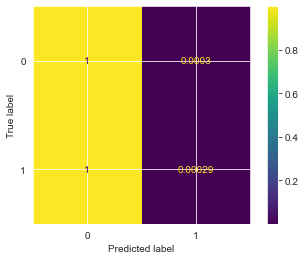

In [41]:
score_and_matrix(rf, X_test, X_train, y_train, y_test)

Again, we see a similar lackluster result.

## 1.2 BoW

Let's look at using a simpler vectorization process, Tfid.

In [152]:
vectorizer = TfidfVectorizer()

In [153]:
q_1['text'] = q_1['text'].apply(clean_text)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(q_1['text'], q_1['target'],\
                                                    test_size = 0.25, random_state = 42)

In [155]:
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [156]:
for vec in [vec_train, vec_test]:
    print(vec.shape)

(60899, 330211)
(20300, 330211)


In [157]:
non_zero_cols = vec_train.nnz / float(vec_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(vec_test.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 89.78612128277969
Percentage of columns containing 0: 0.9997280946991991


In [160]:
bow_nb = MultinomialNB()
bow_rf = RandomForestClassifier(n_estimators=100)

In [161]:
bow_nb.fit(vec_train, y_train)
nb_train_pred = bow_nb.predict(vec_train)
nb_test_pred = bow_nb.predict(vec_test)

In [162]:
bow_rf.fit(vec_train, y_train)
rf_train_pred = bow_rf.predict(vec_train)
rf_test_pred = bow_rf.predict(vec_test)

In [163]:
nb_train_score = accuracy_score(y_train, nb_train_pred)
nb_test_score = accuracy_score(y_test, nb_test_pred)
rf_train_score = accuracy_score(y_train, rf_train_pred)
rf_test_score = accuracy_score(y_test, rf_test_pred)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}"\
      .format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}"\
      .format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8285 		 Testing Accuracy: 0.8289

----------------------------------------------------------------------

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.829


accuracy : 0.8289162561576354
balanced accuracy : 0.5001692589373966
recall : 0.0005762028233938346
precision : 0.3333333333333333


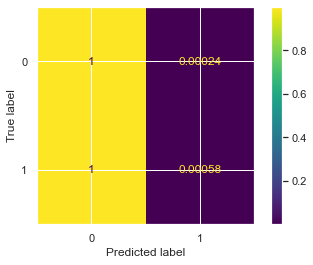

In [164]:
score_and_matrix(bow_rf, vec_test, vec_train, y_train, y_test)

accuracy : 0.8289162561576354
balanced accuracy : 0.49994057876284986
recall : 0.0
precision : 0.0


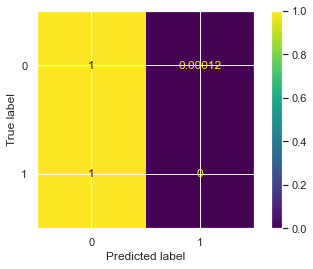

In [165]:
score_and_matrix(bow_nb, vec_test, vec_train, y_train, y_test)

Again, we see a similar pattern. 

Let's try using ROS

In [166]:
ROS = RandomOverSampler()

X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

accuracy : 0.6495073891625616
balanced accuracy : 0.6498000828884316
recall : 0.6502448861999424
precision : 0.2766609463103702


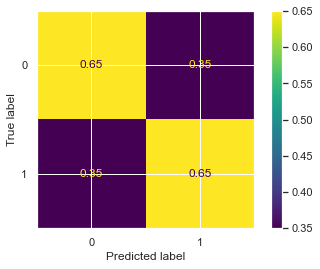

In [167]:
score_and_matrix(bow_nb, vec_test, X_train_ros, y_train_ros, y_test)

accuracy : 0.8283251231527093
balanced accuracy : 0.5028999138708768
recall : 0.008354940939210602
precision : 0.4027777777777778


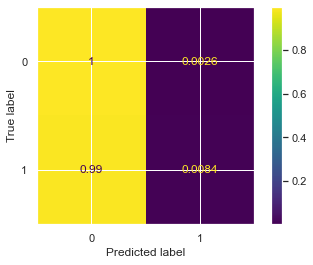

In [169]:
score_and_matrix(bow_rf, vec_test, X_train_ros, y_train_ros, y_test)

In [172]:
# I also wanted to try the XGBoost classifier again as well, to see if the ROS has an effect.

xgb = XGBClassifier(n_estimators=200, max_depth=20, verbosity=1, learning_rate=.5)
xgb.fit(X_train_ros, y_train_ros)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

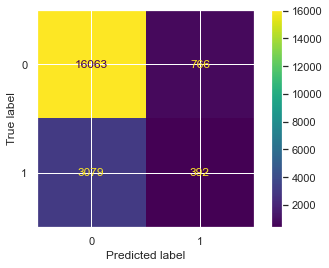

In [173]:
plot_confusion_matrix(xgb, vec_test, y_test)

We finally see a promising result with the Multinomial Naive Bayes model, since it's able to distinguish between the two classes, and has a similar level of accuracy with both being around %65 True Positive/True Negative.

### Changing Target Calculation

However, I'd like to also explore the ability of a model to make further gradations in question quality, to see if the model is able to pick up on a post's score as well.

In [174]:
def q_prep3(data_q, data_a):
    """
    Function to prep the Questions dataframe (first stage)
    Returns dataframe with added features:
        answer_count : # of answers the question received
        target : quality of the question (inverse - lower score, higher quality)
            0 : score > 0 AND answer_count > 0
            1 : score <= 0 AND answer_count > 0
            2 : score > 0 AND answer_count == 0
            3 : score <= 0 AND answer_count ==0
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 'text' and 'target' columns
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target1'] = df['Score'].map(lambda x: 0 if x > 0 else 1)
    df['target2'] = df['answer_count'].map(lambda x: 0 if x > 0 else 2)
    df['target'] = df['target1'] + df['target2']
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target']]

In [175]:
a_6 = time_slice(a_all, 2015, 6, 2016, 1)
q_6 = time_slice(q_all, 2015, 6, 2016, 1)

In [176]:
q_6 = q_prep3(q_6, a_6)

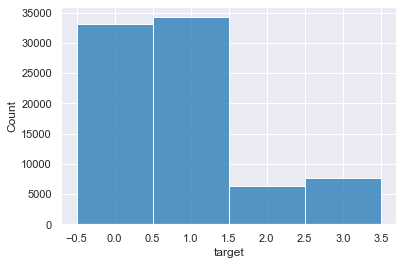

In [178]:
# quick check of class balance
sns.histplot(data=q_6, x='target', discrete=True);

In [179]:
q_6['text'] = q_6['text'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(q_6['text'], q_6['target'],\
                                                    test_size = 0.25, random_state = 42)

vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

ROS = RandomOverSampler()

X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

In [184]:
# an altered score/matrix function, to deal with >2 classes

def score_and_matrix_multi(clf, X_test, X_train, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    tests = [('accuracy', accuracy_score), ('balanced accuracy', balanced_accuracy_score),\
            ('recall', recall_score), ('precision', precision_score)]
    for test, tester in tests:
        if test in ['recall', 'precision']:
            print(test,':',tester(y_test, y_pred, average=None))
        else:
            print(test,':',tester(y_test, y_pred))

accuracy : 0.37098522167487685
balanced accuracy : 0.37240591888550323
recall : [0.41674746 0.33076833 0.45484081 0.28726708]
precision : [0.51482036 0.56022907 0.14684288 0.14647664]


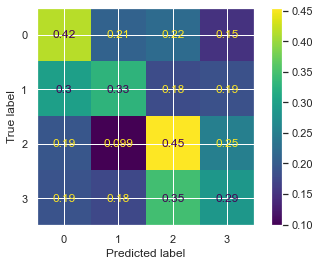

In [185]:
bow_nb = MultinomialNB()

score_and_matrix_multi(bow_nb, vec_test, X_train_ros, y_train_ros, y_test)

### Different approach to text cleaning

I'd like to try a different text cleaning method, incorporating some of the Gensim methods (removing stopwords, stemming, etc)

In [186]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [gsp.strip_tags,
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text_2(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [187]:
def test_model(prep_func, text_cleaner, clf, dates=[(2015,6),(2016,1)]):
    print('Slicing data...')
    a_df = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    q_df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    
    print('Prepping data...')
    q_df = prep_func(q_df, a_df)
    
    print('Cleaning text...')
    q_df['text'] = q_df['text'].apply(text_cleaner)
    
    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(q_df['text'], q_df['target'],\
                                                        test_size = 0.25, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()
    
    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    print('Fitting model...')
    score_and_matrix_multi(clf, vec_test, X_train_ros, y_train_ros, y_test)

Slicing data...
Prepping data...
Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Fitting model...
accuracy : 0.36512315270935963
balanced accuracy : 0.365542743742546
recall : [0.40681047 0.32948583 0.44119558 0.28467909]
precision : [0.50595328 0.53972498 0.14330941 0.14901111]


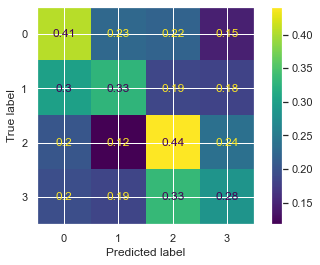

In [188]:
test_model(q_prep3, clean_text_2, bow_nb)

Again, fairly lackluster results. Using the 'score' data doesn't seem to help the model at all.

## Using 60k SO Questions

To switch gears, I'll use some similar methods to try and model the question quality using the "60k Stack Overflow Questions with Quality Rating" dataset:

https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate

This is a much smaller dataset, but includes very useful target information, and perhaps includes question data that was closed/edited, thus giving the model a chance to look at 'actual' low quality posts, as opposed to just lower-performing posts in the Python dataset, that were ultimately not removed or edited.

In [190]:
data2 = pd.read_csv('data.csv', index_col='Unnamed: 0')

In [191]:
data2.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [303]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
 6   text          60000 non-null  object
 7   target        60000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.1+ MB


In [192]:
def test_models(df, text_cleaner, models):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)

    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                      test_size = 0.2, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    for model, clf in models:
        print('='*70)
        print(f'Fitting {model} model...')
        score_and_matrix(clf, vec_test, X_train_ros, y_train_ros, y_test)
        plt.show()

In [193]:
rf =  ('Random Forest', RandomForestClassifier(n_estimators=50))
svc = ('Support Vector Machine', LinearSVC())
lr = ('Logistic Regression', LogisticRegression(max_iter=1000))
xgb = ('XGBoost', xgboost.XGBClassifier())
nb = ('Naive Bayes', MultinomialNB())

models = [rf, svc, lr, xgb, nb]

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Fitting Random Forest model...
accuracy : 0.8218333333333333
balanced accuracy : 0.7611175440622473
recall : 0.5780548628428928
precision : 0.8386396526772794


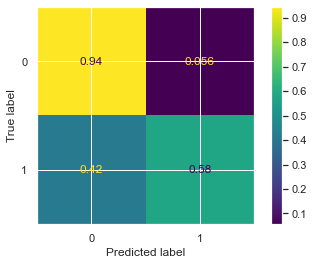

Fitting Support Vector Machine model...
accuracy : 0.8618333333333333
balanced accuracy : 0.8514639558800121
recall : 0.8201995012468828
precision : 0.7782773308092759


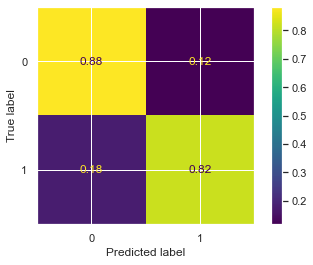

Fitting Logistic Regression model...
accuracy : 0.8619166666666667
balanced accuracy : 0.8591039609986297
recall : 0.8506234413965087
precision : 0.7632579995524726


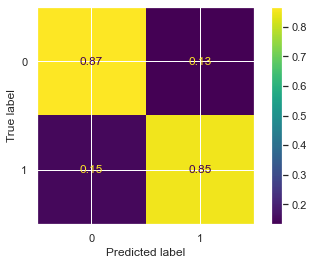

Fitting XGBoost model...
accuracy : 0.8555
balanced accuracy : 0.8429192975009285
recall : 0.8049875311720698
precision : 0.7722488038277512


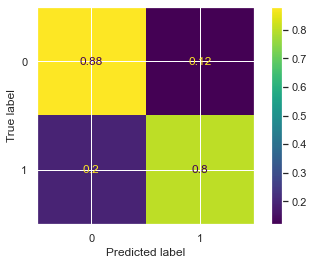

Fitting Naive Bayes model...
accuracy : 0.8154166666666667
balanced accuracy : 0.8323217300927905
recall : 0.8832917705735661
precision : 0.6696918131972017


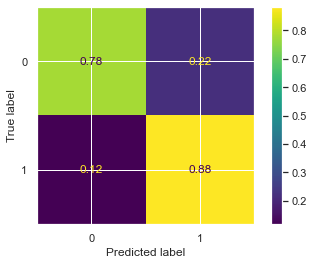

In [194]:
test_models(data2, clean_text, models)

Because of the best/most balanced results coming from the Logistic Regression model, I'll do a little parameter tuning:

In [243]:
def grid_search_lr(df, text_cleaner):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)

    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                      test_size = 0.2, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    for solver, penalty in [
        ('newton-cg', 'l2'),
        ('liblinear', 'l1'), ('liblinear', 'l2'),
        ('lbfgs', 'l2')
    ]:
        for C in [.1, 1, 10]:
            t0 = time()
            print('='*70)
            print(f"Testing solver:{solver} | penalty:{penalty} | C={C}")
            lr = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=1000)
            score_and_matrix(lr, vec_test, X_train_ros, y_train_ros, y_test)
            plt.show()
            print(f"training time: {time()-t0}")

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Testing solver:newton-cg | penalty:l2 | C=0.1
accuracy : 0.838
balanced accuracy : 0.839777589817696
recall : 0.8451371571072319
precision : 0.7192275042444821


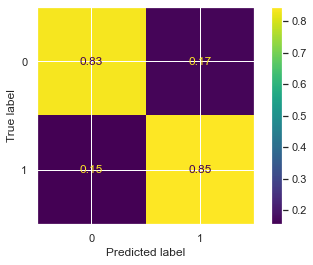

training time: 1.430967092514038
Testing solver:newton-cg | penalty:l2 | C=1
accuracy : 0.861
balanced accuracy : 0.8572976195306476
recall : 0.8461346633416459
precision : 0.7635013501350135


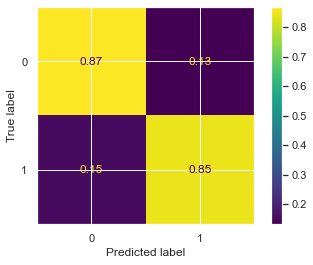

training time: 1.9512381553649902
Testing solver:newton-cg | penalty:l2 | C=10
accuracy : 0.8648333333333333
balanced accuracy : 0.8547105328044096
recall : 0.8241895261845387
precision : 0.7828043581241118


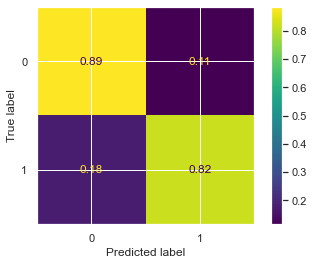

training time: 2.902890920639038
Testing solver:liblinear | penalty:l1 | C=0.1
accuracy : 0.8175833333333333
balanced accuracy : 0.8164958380019913
recall : 0.813216957605985
precision : 0.6936821952776006


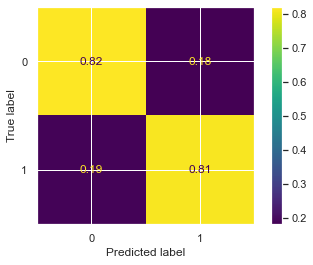

training time: 0.6360058784484863
Testing solver:liblinear | penalty:l1 | C=1
accuracy : 0.8568333333333333
balanced accuracy : 0.8536097178830147
recall : 0.8438902743142145
precision : 0.7560321715817694


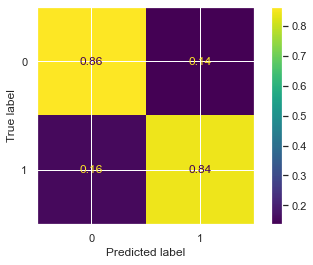

training time: 1.2427117824554443
Testing solver:liblinear | penalty:l1 | C=10
accuracy : 0.84825
balanced accuracy : 0.8320714172016768
recall : 0.7832917705735661
precision : 0.7674077693623259


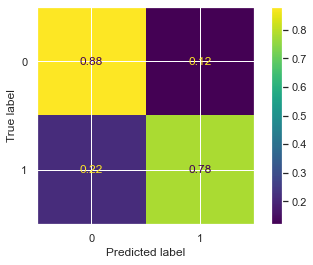

training time: 4.074038982391357
Testing solver:liblinear | penalty:l2 | C=0.1
accuracy : 0.8379166666666666
balanced accuracy : 0.8397150115949176
recall : 0.8451371571072319
precision : 0.7190748992149374


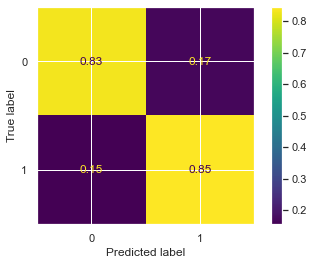

training time: 1.9184861183166504
Testing solver:liblinear | penalty:l2 | C=1
accuracy : 0.861
balanced accuracy : 0.8572976195306476
recall : 0.8461346633416459
precision : 0.7635013501350135


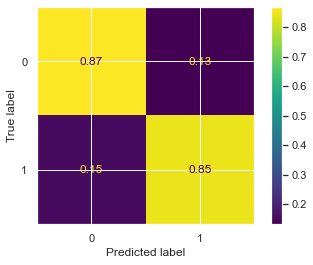

training time: 3.6585617065429688
Testing solver:liblinear | penalty:l2 | C=10
accuracy : 0.8648333333333333
balanced accuracy : 0.8547105328044096
recall : 0.8241895261845387
precision : 0.7828043581241118


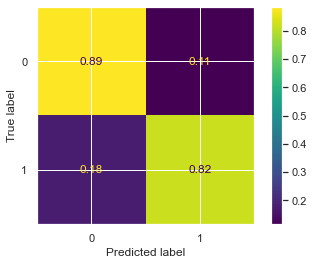

training time: 6.725423097610474
Testing solver:lbfgs | penalty:l2 | C=0.1
accuracy : 0.838
balanced accuracy : 0.839777589817696
recall : 0.8451371571072319
precision : 0.7192275042444821


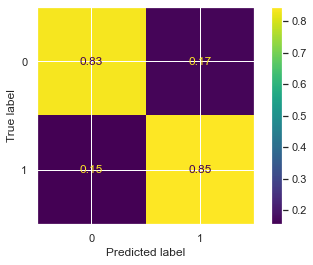

training time: 1.1466381549835205
Testing solver:lbfgs | penalty:l2 | C=1
accuracy : 0.861
balanced accuracy : 0.8572976195306476
recall : 0.8461346633416459
precision : 0.7635013501350135


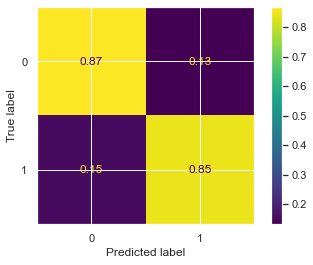

training time: 2.9675920009613037
Testing solver:lbfgs | penalty:l2 | C=10
accuracy : 0.86475
balanced accuracy : 0.854647954581631
recall : 0.8241895261845387
precision : 0.782618991238456


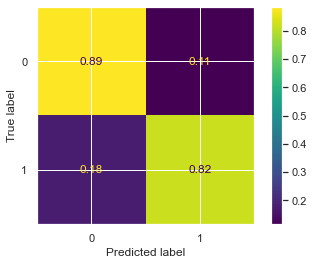

training time: 14.063766956329346


In [244]:
grid_search_lr(data2, clean_text)

None of the parameter combinations does better than the vanilla model, and I'm pretty happy with the .87/.85 accuracy between the two classes.

This means that a large majority of both classes are correctly predicted, and this wouldn't lead to a massive amount of false negatives/positives which would annoy users who write good questions, and wouldn't catch poor quality posts.

### Generalize to Bigger Dataset?

I'd like to also see if this model has any ability to predict the original quality indicators of the Python dataset.

In [195]:
def q_prep4(data_q, data_a):
    """
    Simpler version of function to prep the Questions dataframe (first stage)
    Returns dataframe with added feature:
        answer_count : # of answers the question received
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df

In [196]:
def fit_models(df_sm, prep_func, text_cleaner, models, dates=[(2016,1),(2016,11)]):
    print('Slicing data...')
    a_df = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    
    print('Prepping data...')
    df = prep_func(df, a_df)
    
    print('Cleaning text...')
    df['text'] = df['text'].apply(text_cleaner)
    df_sm['text'] = (df_sm['Title']+' '+df_sm['Body']).apply(text_cleaner)

    df_sm['target'] = df_sm['Y'].map(lambda x: 1 if x=='HQ' else 0)
    
    print('Vectorizing data...')
    X_2 = vectorizer.fit_transform(df_sm['text'])
    X = vectorizer.transform(df['text'])
    
    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_2, y_2 = ROS.fit_resample(X_2, df_sm['target'])
    
    final_models = []
    
    for model, clf in models:
        print('='*70)
        print(f'Fitting using {model} model...')
        clf.fit(X_2, y_2)
        
        final_models.append((model, clf))
    
    return {'final_models':final_models, 'X':X}

In [197]:
fitted_models = fit_models(data2, q_prep4, clean_text, models)

Slicing data...
Prepping data...
Cleaning text...
Vectorizing data...
Random over-sampling...
Fitting using Random Forest model...
Fitting using Support Vector Machine model...
Fitting using Logistic Regression model...
Fitting using XGBoost model...
Fitting using Naive Bayes model...


In [198]:
lr_fit = fitted_models['final_models'][2][1]
df_text = fitted_models['X']
y_pred = lr_fit.predict(df_text)

In [199]:
dates=[(2016,1),(2016,11)]
new_df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
new_df_a = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
new_df = q_prep4(new_df, new_df_a)

In [200]:
new_df['target']=y_pred

In [201]:
new_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,answer_count,target1,target2,target,text
476742,34552552,5732525.0,2016-01-01 00:00:39,2,Selenium Firefox webdriver won't load a blank ...,<p>everyone. </p>\n\n<p>Main question: I am us...,1,1,1,1,Selenium Firefox webdriver won't load a blank ...
476743,34552584,5635159.0,2016-01-01 00:07:19,1,Is there any chance I got memory leak with pyt...,<p>Happy new year to all of you!\nI trained a ...,0,1,0,1,Is there any chance I got memory leak with pyt...
476744,34552670,1876983.0,2016-01-01 00:26:13,1,Why is my Runge-Kutta Python script defining e...,"<p>I am a newcomer to Python, my knowledge of ...",1,1,1,1,Why is my Runge-Kutta Python script defining e...
476745,34552671,5731951.0,2016-01-01 00:26:25,0,Frequency to Midi Converter python math error,"<p>This is a frequency to midi note converter,...",2,1,1,0,Frequency to Midi Converter python math error ...
476746,34552706,4180276.0,2016-01-01 00:35:34,0,Stream file to iphone with flask,<p>I am currently doing a file conversion on t...,0,1,0,1,Stream file to iphone with flask <p>I am curre...


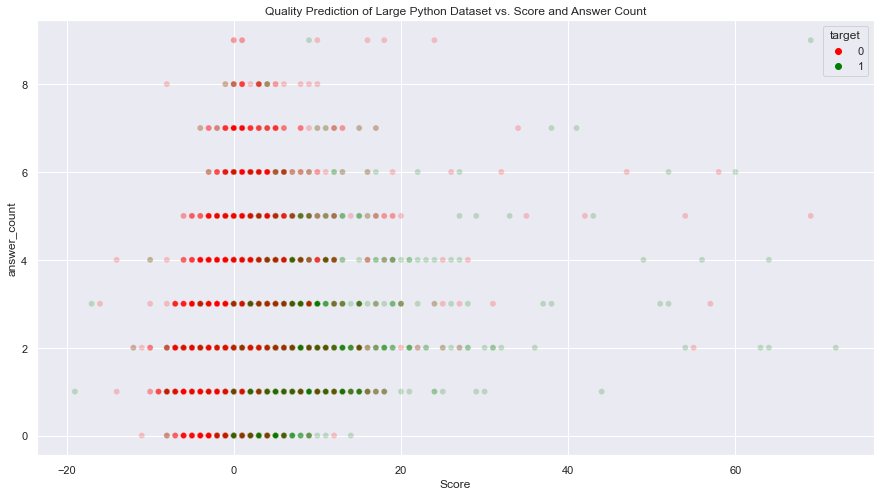

In [229]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=new_df[(new_df['answer_count']<10) & (new_df['Score']<75)],\
                y='answer_count', x='Score', hue='target', alpha=.2, palette=['r','g'])
ax.set_title('Quality Prediction of Large Python Dataset vs. Score and Answer Count');

This at least shows that the model does have an ability to say something about the larger dataset - if we had access to similar data on the scale of the Python dataset, this would likely be even more effective.

In [87]:
new_df1 = new_df[new_df['target']==1]
new_df0 = new_df[new_df['target']==0]

In [88]:
new_df1.answer_count.mean()

0.9919553791697951

In [89]:
new_df0.answer_count.mean()

1.374423627812926

In [90]:
len(new_df0[new_df0['answer_count']==0])/len(new_df0), len(new_df0[new_df0['answer_count']>0])/len(new_df0)

(0.17883239632960063, 0.8211676036703993)

In [91]:
len(new_df1[new_df1['answer_count']==0])/len(new_df1), len(new_df1[new_df1['answer_count']>0])/len(new_df1)

(0.2775777263603071, 0.7224222736396929)

In [92]:
new_df1.Score.mean()

0.7878671794793215

In [93]:
new_df0.Score.mean()

0.36964414283307034

In [94]:
len(new_df1), len(new_df0)

(65261, 65279)

And above, these average scores and value counts show that the model does somewhat well at correllating the 'quality' target to posts' scores, but the answer_count is not correlated at all.

*********************
<a id="a_q"></a>
# 2. Answer Quality
[Back to Top](#top) | [Previous Section](#q_q) | [Next Section](#t_p)

In this section, I will employ similar techniques to try and predict the Score of answers submitted to questions.

In [181]:
a_all = pd.read_csv('../zippedData/Answers.csv', encoding='latin1')

In [96]:
a_all.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [207]:
# I'll define 'low quality' as having a score of 0 or lower, and 'high quality' as anything above 0.
def a_target(x):
    if x > 0:
        return 1
    else:
        return 0

a_all['target'] = a_all['Score'].map(a_target)

In [208]:
a_all.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,target
0,497,50.0,2008-08-02 16:56:53,469,4,<p>open up a terminal (Applications-&gt;Utilit...,1
1,518,153.0,2008-08-02 17:42:28,469,2,<p>I haven't been able to find anything that d...,1
2,536,161.0,2008-08-02 18:49:07,502,9,<p>You can use ImageMagick's convert utility f...,1
3,538,156.0,2008-08-02 18:56:56,535,23,<p>One possibility is Hudson. It's written in...,1
4,541,157.0,2008-08-02 19:06:40,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",1


In [209]:
a_all['CreationDate'] = pd.to_datetime(a_all['CreationDate'], infer_datetime_format=True) 

In [210]:
a2 = time_slice(a_all, 2015, 6, 2016, 1)
len(a2)

116082

In [211]:
len(a2[a2['target']==1])

68803

In [212]:
len(a2[a2['target']==0])

47279

In [5]:
# Re-formualation of the text cleaning function.

filters = [gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text_3(s):
    # remove code
    s = re.sub('<pre><code>.*?</code></pre>', '', s)
    # remove html tags
    s = re.compile(r'<.*?>').sub(r'', s)
    # remove links
    s = re.compile(r'https?://\S+|www\.\S+').sub(r'', s)
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [214]:
a2['text'] = a2['Body'].map(clean_text_3)
a2.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,target,text
697812,30563958,849891.0,2015-06-01 00:00:00,30553925,6,"<p>The odds, i.e. 2-coprimes, are generated by...",1,odd coprim gener roll wheel repeat addit start...
697813,30563963,3842697.0,2015-06-01 00:00:44,30563725,1,<p>I think the issue here is that you're attem...,1,think issu attempt valu entri self app mainloo...
697814,30563970,400617.0,2015-06-01 00:01:53,30563807,2,"<p>If you want to make the ""long"" function cal...",1,want long function decor function result exact...
697815,30563976,4621258.0,2015-06-01 00:02:57,30560168,1,"<p>For users of Ubuntu, a solution does exist....",1,user ubuntu solut exist enter synapt packag ma...
697816,30563983,359284.0,2015-06-01 00:04:05,30541152,1,<p>The problem you are seeing is that you are ...,1,problem see modifi serial data outsid actual p...


In [215]:
rf =  ('Random Forest', RandomForestClassifier(n_estimators=100))
svc = ('Support Vector Machine', LinearSVC())
lr = ('Logistic Regression', LogisticRegression(max_iter=1000))
xgb = ('XGBoost', xgboost.XGBClassifier())
nb = ('Naive Bayes', MultinomialNB())

models = [rf, svc, lr, xgb, nb]

Vectorizing data...
Random over-sampling...
Fitting Random Forest model...
accuracy : 0.6069690313132619
balanced accuracy : 0.5718360992709753
recall : 0.768527992983482
precision : 0.6383172464032052


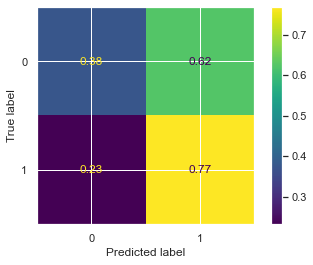

Fitting Support Vector Machine model...
accuracy : 0.577292501184477
balanced accuracy : 0.5675417742141582
recall : 0.6221312673585733
precision : 0.6470051687442991


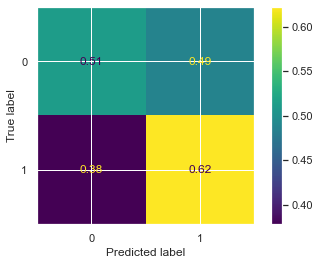

Fitting Logistic Regression model...
accuracy : 0.5841409312141965
balanced accuracy : 0.5791695395609326
recall : 0.6070019003069727
precision : 0.6600174839068584


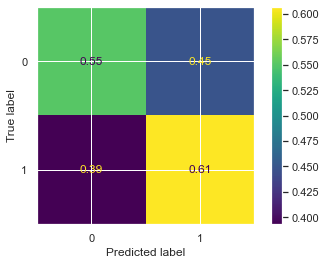

Fitting XGBoost model...
accuracy : 0.5748374036266529
balanced accuracy : 0.5810507790752677
recall : 0.5462651659114165
precision : 0.6710963455149501


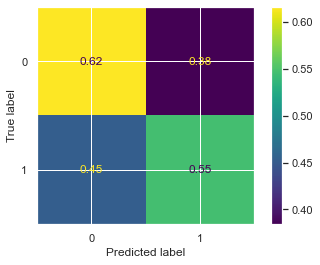

Fitting Naive Bayes model...
accuracy : 0.580565964594909
balanced accuracy : 0.5717496077469302
recall : 0.6211080251425231
precision : 0.6510879558688324


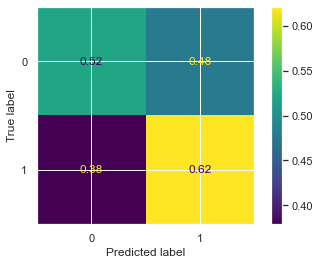

In [216]:
X_train, X_test, y_train, y_test = train_test_split(a2['text'], a2['target'],\
                                                      test_size = 0.2, random_state = 42)
print('Vectorizing data...')
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

ROS = RandomOverSampler()

print('Random over-sampling...')
X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

for model, clf in models:
    print('='*70)
    print(f'Fitting {model} model...')
    score_and_matrix(clf, vec_test, X_train_ros, y_train_ros, y_test)
    plt.show()

Because of poor results, time constraints, and the lack of a similar alternate dataset (like the 60k quality-rated questions) I'll abandon the answer quality modelling component.

*********************
<a id="t_p"></a>
# 3. Tag Prediction
[Back to Top](#top) | [Previous Section](#a_q) | [Next Section](#t_p)

For this section, I'll attempt to model and predict posts' tags. This is a more complex problem than predicting quality, since there are potentially as many target classes as there are tags, and any question can have one or many tags associated with it.

In addition, once I am able to build a basic model, I'll target the ability of the model to predict the correct tags in its 'top 20' tags predicted, as this will enable a feature to suggest 20 tags for a given question, which the user can use to select which tags apply to the post.

In [252]:
tags_all = pd.read_csv('../zippedData/Tags.csv')

In [253]:
tags_all.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [254]:
print(len(tags_all.Tag.unique()) , 'unique tags')

16896 unique tags


In [255]:
q14 = time_slice(q_all, 2014, 1, 2014, 4)
q14.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
233194,20864531,805981.0,2014-01-01 00:26:39,0,How to create tables for flask app using peewe...,<p>I'm new to peewee orm. </p>\n\n<p>Peewee us...
233195,20864554,523463.0,2014-01-01 00:32:49,1,Getting a 'got multiple values for keyword arg...,<p>So I'm generating a two-week expired-domain...
233196,20864610,2460370.0,2014-01-01 00:44:39,0,Cannot import Twython,<p>I installed Twython 1.2 using the Windows i...
233197,20864620,2544396.0,2014-01-01 00:46:35,1,Python curses: addstr() from file prints blank...,<p>I'm writing a very simple farming game in P...
233198,20864847,3084006.0,2014-01-01 01:35:33,17,Probability to z-score and vice versa in python,"<p>I have numpy, statsmodel, pandas, and scipy..."


In [256]:
tags14 = tags_all[tags_all['Id'].isin(q14['Id'].unique())]

In [257]:
','.join(list(tags14[tags14['Id']==20864531]['Tag']))

'python,django,postgresql,flask,peewee'

In [258]:
# putting all tags in a list for each post

q14['tags'] = q14['Id'].apply(lambda x: ([str(y) for y in list(tags14[tags14['Id']==x]['Tag'])]))

In [259]:
q14.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,tags
233194,20864531,805981.0,2014-01-01 00:26:39,0,How to create tables for flask app using peewe...,<p>I'm new to peewee orm. </p>\n\n<p>Peewee us...,"[python, django, postgresql, flask, peewee]"
233195,20864554,523463.0,2014-01-01 00:32:49,1,Getting a 'got multiple values for keyword arg...,<p>So I'm generating a two-week expired-domain...,"[python, django, django-views]"
233196,20864610,2460370.0,2014-01-01 00:44:39,0,Cannot import Twython,<p>I installed Twython 1.2 using the Windows i...,"[python, twitter, twython]"
233197,20864620,2544396.0,2014-01-01 00:46:35,1,Python curses: addstr() from file prints blank...,<p>I'm writing a very simple farming game in P...,"[python, curses, ascii-art]"
233198,20864847,3084006.0,2014-01-01 01:35:33,17,Probability to z-score and vice versa in python,"<p>I have numpy, statsmodel, pandas, and scipy...","[python, statistics]"


In [260]:
# I'll employ the MultiLabelBinarizer to create the target matrix

y = []
for index, row in q14[['tags']].iterrows():
    y.append(set(row['tags']))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(y)

In [261]:
len(encoded_y[0])

5190

Because of the massive number of tags, we need to find out how many (or few!) tags we can include in the model, and how that compares with how many posts will have at least one of those top tags.

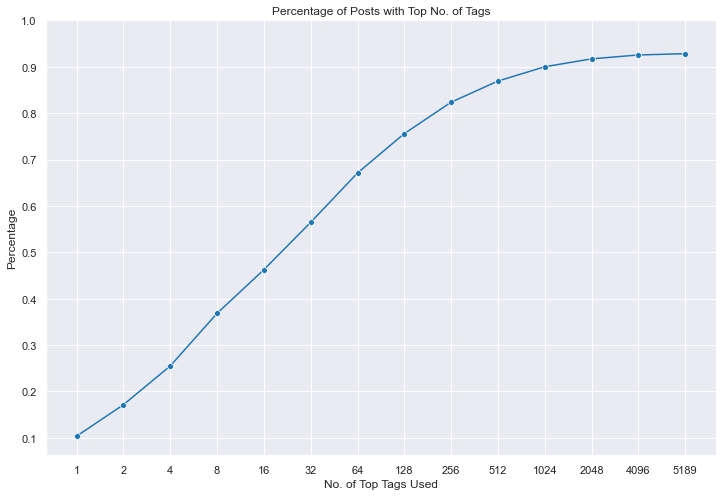

In [262]:
# Here, I'll do some data engineering to find the % of posts with n number of the top tags (by count)

q14['text'] = q14['Title']+' '+q14['Body']
q14['text'] = q14['text'].apply(clean_text)

tag_per_id = tags14.groupby('Id').size()
id_per_tag = tags14.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)

top_tag_counts = [str(2**x) for x in range(0,13)]+[str(len(idtag_df))]
top_tag_pcts = []
for count in top_tag_counts:
    top_tags = list(idtag_df.iloc[-(int(count)+1):-1]['tag'])
    top_tag_pcts.append(len(tags14[tags14['Tag'].isin(top_tags)].groupby('Id').size())/len(tagid_df))
    
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=top_tag_counts, y=top_tag_pcts, marker='o')

ax.set_yticks([x/10 for x in range(1,11)])
ax.set_xticks(top_tag_counts)

ax.set_title("Percentage of Posts with Top No. of Tags")
ax.set_xlabel('No. of Top Tags Used')
ax.set_ylabel('Percentage');

Once we hit 256 tags, we're dealing with over 80% of posts, so this is a good place to start our experiments.

In [263]:
top_256 = idtag_df.iloc[-256:].tag.values

raw_y = []
for index, row in q14[['tags']].iterrows():
    raw_y.append(set([x for x in row['tags'] if x in top_256]))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(raw_y)

In [264]:
X_train, X_test, y_train, y_test = train_test_split(q14['text'], encoded_y,\
                                                    random_state=42, test_size=0.2)

for chunk in [X_train, X_test, y_train, y_test]:
    print(chunk.shape)

(23584,)
(5896,)
(23584, 256)
(5896, 256)


In [265]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Models

* Classifier Chain - random forest classifier

* OneVsRest Classifier - SGD/logistic classifier

In [268]:
classifier_chain_model = ClassifierChain(RandomForestClassifier())

In [269]:
t0 = time()
classifier_chain_model.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
print('Hamming loss for test data :', hamming_loss(classifier_chain_model,\
                                                   X_train, y_train, X_test, y_test))
test_time = time() - t0
print("test time: %0.3fs" % test_time)

train time: 830.086s
Hamming loss for test data : 0.004905338364993216
test time: 40.186s


In [270]:
def top20_score(clf, mlb, X_test, y_test):
    y_pred = clf.predict_proba(X_test)
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    tag_scores = []
    post_scores = []
    for i, x in enumerate(mlb.inverse_transform(y_test)):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                post_score += 1
            else:
                tag_scores.append(0)
        if x:
            post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(tag_scores), ones/len(y_test), np.mean(post_scores)

In [275]:
sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=10**-6, penalty='l1'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
predictions = sgd_log_clf.predict(X_test)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions, zero_division=0))

accuracy : 0.34073948439620083
macro f1 score : 0.39229906568927236
micro f1 scoore : 0.7515242695383642
hamming loss : 0.004158009667571235
Precision recall report :
               precision    recall  f1-score   support

           0       0.71      0.29      0.42        17
           1       0.40      0.17      0.24        46
           2       0.75      0.55      0.63        11
           3       0.60      0.60      0.60        10
           4       0.50      0.50      0.50        16
           5       0.20      0.12      0.15         8
           6       0.91      0.48      0.62        21
           7       0.00      0.00      0.00        19
           8       0.50      0.29      0.36         7
           9       0.00      0.00      0.00         8
          10       1.00      0.71      0.83        14
          11       1.00      0.12      0.22         8
          12       0.55      0.35      0.43       110
          13       0.33      0.18      0.24        11
          14       0.

In [276]:
t0 = time()
sgd_log_clf.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
print('Hamming loss for test data :', hamming_loss(sgd_log_clf,\
                                                   X_train, y_train, X_test, y_test))
test_time = time() - t0
print("test time: %0.3fs" % test_time)

train time: 10.550s
Hamming loss for test data : 0.004140121480664858
test time: 0.295s


In [277]:
top20_score(sgd_log_clf, mlb, X_test, y_test)

(0.921173235563703, 0.8312415196743554, 0.9373530076888286)

Although these results look promising, I have a few concerns:

- Since we're only dealing with Python questions (all have the python tag), that leaves many with no tag BUT 'Python', so this should likely be directed at the larger '10% of Stack Overflow Questions' dataset. As well, 

## Using 10% of all SO Q&A dataset

I'll turn to the "10% of Stack Overflow Q&A" dataset:

https://www.kaggle.com/datasets/stackoverflow/stacksample?datasetId=265&sortBy=commentCount

This will allow the model to deal with a broader cross-section of questions, and be more directly applicable to a real-world implementation.

In [6]:
qbig = pd.read_csv('../zippedData/archive/Questions.csv', encoding='latin1')
tbig = pd.read_csv('../zippedData/archive/Tags.csv', encoding='latin1')

In [11]:
qbig.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
qbig['CreationDate'] = pd.to_datetime(qbig['CreationDate'], infer_datetime_format=True)

In [20]:
# Create initial subset (1 year of questions)

qbig2 = time_slice(qbig, 2015, 1, 2016, 1)

In [21]:
tbig2 = tbig[tbig['Id'].isin(qbig2['Id'].unique())]

In [22]:
len(qbig2), len(tbig2)

(230038, 693626)

In [23]:
qbig2['tags'] = qbig2['Id'].apply(lambda x: ([str(y) for y in list(tbig2[tbig2['Id']==x]['Tag'])]))

In [24]:
qbig2.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,tags
823129,27727410,541091.0,2015-01-01 00:06:41,NaN,0,Can Sequel be forced to always return autoincr...,<p>I'm working with Sequel (4.x) and MySQL 5.5...,"[mysql, ruby, sequel, on-duplicate-key]"
823130,27727520,4409403.0,2015-01-01 00:34:15,NaN,0,C# - Get Python logging stream,<p>i have a little question. Is it possible to...,"[c#, python, logging]"
823131,27727530,988445.0,2015-01-01 00:37:18,NaN,0,Receiving SIGSEGV (11) errors in many places,<p>I've been receiving <code>SIGSEGV (11)</cod...,"[delphi, firemonkey, sigsegv, delphi-xe7]"
823132,27727550,1461017.0,2015-01-01 00:42:04,NaN,3,Linux shell: Adding dots to numerical outputs ...,<p>This is a common output for <strong>some nu...,"[linux, bash, numbers]"
823133,27727560,3448171.0,2015-01-01 00:44:15,NaN,1,Login script in javascript failed,<p>Im creating login script which are based on...,"[javascript, php, login]"


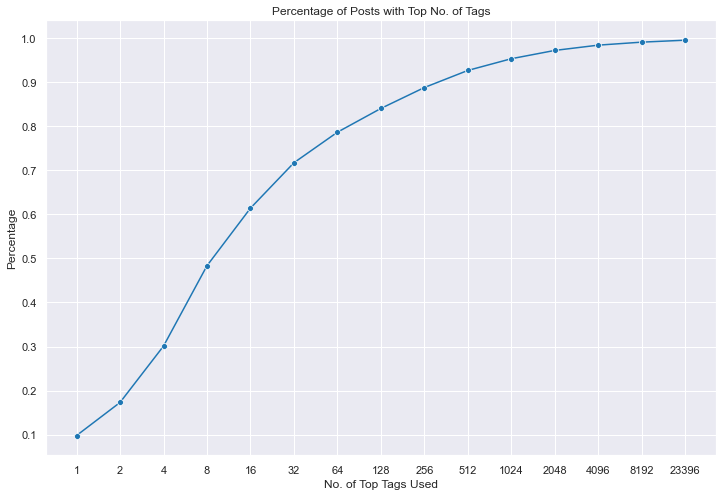

In [25]:
# Similar graph as above - what percentage of posts have at least one of the top n tags?

qbig2['text'] = qbig2['Title']+' '+qbig2['Body']
qbig2['text'] = qbig2['text'].apply(clean_text)

tag_per_id = tbig2.groupby('Id').size()
id_per_tag = tbig2.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)

top_tag_counts = [str(2**x) for x in range(0,14)]+[str(len(idtag_df))]
top_tag_pcts = []
for count in top_tag_counts:
    top_tags = list(idtag_df.iloc[-(int(count)+1):-1]['tag'])
    top_tag_pcts.append(len(tbig2[tbig2['Tag'].isin(top_tags)].groupby('Id').size())/len(tagid_df))
    
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=top_tag_counts, y=top_tag_pcts, marker='o')

ax.set_yticks([x/10 for x in range(1,11)])
ax.set_xticks(top_tag_counts)

ax.set_title("Percentage of Posts with Top No. of Tags")
ax.set_xlabel('No. of Top Tags Used')
ax.set_ylabel('Percentage');

In [26]:
y = []
for index, row in qbig2[['tags']].iterrows():
    y.append(set(row['tags']))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(y)

In [27]:
top_256 = idtag_df.iloc[-256:].tag.values

raw_y = []
for index, row in qbig2[['tags']].iterrows():
    raw_y.append(set([x for x in row['tags'] if x in top_256]))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(raw_y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(qbig2['text'], encoded_y,\
                                                    random_state=42, test_size=0.2, )

for chunk in [X_train, X_test, y_train, y_test]:
    print(chunk.shape)

(184030,)
(46008,)
(184030, 256)
(46008, 256)


In [29]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Model

- This time, I'll just deal with the OneVsRest classifier - the chain classifier is prohibitive in training time, and didn't provide noticably different performance.

In [30]:
t0 = time()

sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='log_loss'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
predictions = sgd_log_clf.predict(X_test)

train_time = time() - t0
print("train time: %0.3fs" % train_time)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions, zero_division=0))

train time: 73.851s
accuracy : 0.15195183446357155
macro f1 score : 0.03712236839359977
micro f1 scoore : 0.25234382204371036
hamming loss : 0.006195338989958268
Precision recall report :
               precision    recall  f1-score   support

           0       1.00      0.14      0.25       210
           1       0.00      0.00      0.00       509
           2       0.00      0.00      0.00        89
           3       0.00      0.00      0.00        87
           4       0.86      0.09      0.17       531
           5       0.00      0.00      0.00       264
           6       0.00      0.00      0.00        84
           7       0.00      0.00      0.00       177
           8       0.95      0.49      0.65      3476
           9       0.00      0.00      0.00        92
          10       0.00      0.00      0.00       162
          11       0.00      0.00      0.00        85
          12       0.00      0.00      0.00       127
          13       0.00      0.00      0.00       233


In [33]:
def top20_score(clf, mlb, X_test, y_test):
    y_pred = clf.predict_proba(X_test)
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    tag_scores = []
    post_scores = []
    for i, x in enumerate(mlb.inverse_transform(y_test)):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                post_score += 1
            else:
                tag_scores.append(0)
        if x:
            post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(tag_scores), ones/len(y_test), np.mean(post_scores)

In [34]:
top20_score(sgd_log_clf, mlb, X_test, y_test)

(0.8108062269065358, 0.618001217179621, 0.8254248742372259)

We see diminished performance, which is to be somewhat expected because of the greater diversity of questions.

Let's test hyperparameters and see if we can get better results.

In [35]:
param_test_results = {
    'alpha_value' : [],
    'loss_metric' : [],
    'penalty_value' : [],
    'pct_tags_pred' : [],
    'pct_perfect' : [],
    'avg_post_score' : [],
    'hammingloss_score' : []
}

In [36]:
def append_data(a, l, p, pct_t, pct_p, avg_post_score, hls):
    param_test_results['alpha_value'].append(a)
    param_test_results['loss_metric'].append(l)
    param_test_results['penalty_value'].append(p)
    param_test_results['pct_tags_pred'].append(pct_p)
    param_test_results['pct_perfect'].append(pct_t)
    param_test_results['avg_post_score'].append(avg_post_score)
    param_test_results['hammingloss_score'].append(hls)

In [37]:
alphas = [10**-x for x in [3,4,5,6,7]]
losses = ['log_loss', 'modified_huber']
penalties = ['l1', 'l2']

for alpha in alphas:
    for loss in losses:
        for penalty in penalties:
            t0 = time()
            print("="*70)
            print(f'TESTING: alpha:{alpha} / loss:{loss} / penalty:{penalty}')
            sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss=loss, alpha=alpha, penalty=penalty), n_jobs=-1)
            sgd_log_clf.fit(X_train, y_train)
            predictions = sgd_log_clf.predict(X_test)
            train_time = time() - t0
            print("train time: %0.3fs" % train_time)
            
            hls = metrics.hamming_loss(y_test,predictions)
            top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
            append_data(alpha, loss, penalty, top20_scores[0], top20_scores[1], top20_scores[2], hls)
            

TESTING: alpha:0.001 / loss:log_loss / penalty:l1
train time: 116.759s
TESTING: alpha:0.001 / loss:log_loss / penalty:l2
train time: 94.416s
TESTING: alpha:0.001 / loss:modified_huber / penalty:l1
train time: 108.170s
TESTING: alpha:0.001 / loss:modified_huber / penalty:l2
train time: 57.261s
TESTING: alpha:0.0001 / loss:log_loss / penalty:l1
train time: 108.736s
TESTING: alpha:0.0001 / loss:log_loss / penalty:l2
train time: 71.324s
TESTING: alpha:0.0001 / loss:modified_huber / penalty:l1
train time: 99.779s
TESTING: alpha:0.0001 / loss:modified_huber / penalty:l2
train time: 58.220s
TESTING: alpha:1e-05 / loss:log_loss / penalty:l1
train time: 113.164s
TESTING: alpha:1e-05 / loss:log_loss / penalty:l2
train time: 68.556s
TESTING: alpha:1e-05 / loss:modified_huber / penalty:l1
train time: 134.629s
TESTING: alpha:1e-05 / loss:modified_huber / penalty:l2
train time: 57.185s
TESTING: alpha:1e-06 / loss:log_loss / penalty:l1
train time: 128.179s
TESTING: alpha:1e-06 / loss:log_loss / penal

In [38]:
param_df = pd.DataFrame(param_test_results)
display(param_df)

,alpha_value,loss_metric,penalty_value,pct_tags_pred,pct_perfect,avg_post_score,hammingloss_score
0,1.000000e-03,log_loss,l1,0.344527,0.567145,0.588666,0.006737
1,1.000000e-03,log_loss,l2,0.398409,0.623999,0.642833,0.006958
2,1.000000e-03,modified_huber,l1,0.645105,0.831425,0.843936,0.005935
3,1.000000e-03,modified_huber,l2,0.840789,0.960628,0.966278,0.006096
4,1.000000e-04,log_loss,l1,0.677882,0.854395,0.866602,0.005597
5,1.000000e-04,log_loss,l2,0.617871,0.810758,0.825425,0.006192
6,1.000000e-04,modified_huber,l1,0.809424,0.940929,0.945968,0.004953
7,1.000000e-04,modified_huber,l2,0.844158,0.962517,0.968363,0.004890
8,1.000000e-05,log_loss,l1,0.816445,0.945448,0.951448,0.004777
9,1.000000e-05,log_loss,l2,0.820140,0.947665,0.954348,0.005051


In [39]:
param_df['loss_penalty'] = param_df['loss_metric']+param_df['penalty_value']

In [40]:
param_df2 = param_df[['alpha_value', 'loss_penalty', 'pct_tags_pred']].copy()
param_df2['alpha_value'] = param_df2['alpha_value'].apply(str)

<AxesSubplot:xlabel='alpha_value', ylabel='pct_tags_pred'>

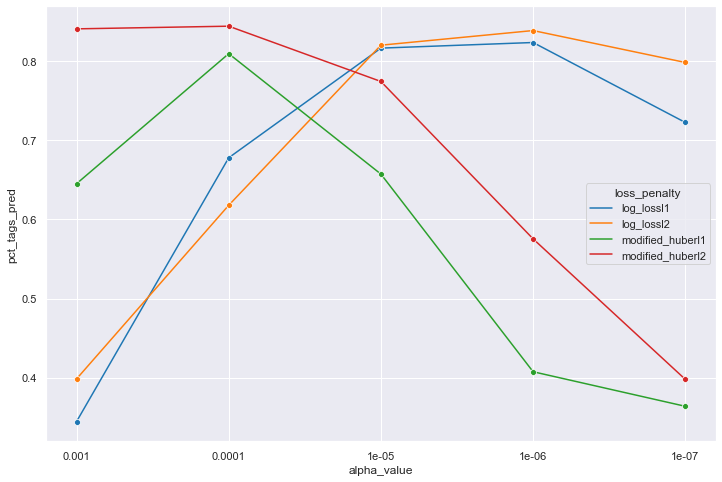

In [41]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=param_df2, x='alpha_value', y='pct_tags_pred', hue='loss_penalty', marker='o')

This graph gives us a look at the performance across 3 different hyperparamaters.

The best-performing model uses:

- alpha: 0.0001
- loss function: 'modified_huber'
- penalty: 'l2'

## Fitting best model to 500,000 posts

Let's attempt to build a much larger model, to see if the performance is better.

In [53]:
def fit_best_model(questions, tags, text_cleaner, n=500000, top=256):
    t0 = time()
    print('='*70)
    print('='*70)
    print('Prepping data...')
    
    if n == 0:
        n = len(questions)
    
    questions = questions.copy()
    questions = questions.iloc[-n:]
    
    questions['text'] = questions['Title']+' '+questions['Body']
    questions['text'] = questions['text'].apply(text_cleaner)
    questions['tags'] = questions['Id'].apply(lambda x: ([str(y) for y in list(tags[tags['Id']==x]['Tag'])]))
    
    print(f'Prep time: {time()-t0}')
    
    qTrain = questions.iloc[:-(int(n/5))]
    qTest = questions.iloc[-int(n/5):]
    print(f'# of posts in train set: {len(qTrain)}')
    print(f'# of posts in test set: {len(qTest)}')
    
    t0 = time()
    print('Prepping tag info...')
    tTrain = tags[tags['Id'].isin(qTrain['Id'].unique())]
    tTest = tags[tags['Id'].isin(qTest['Id'].unique())]
    
    tag_per_id = tTrain.groupby('Id').size()
    id_per_tag = tTrain.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
    
    top_tags = idtag_df.iloc[-top:].tag.values

    raw_ytrain = []
    for index, row in qTrain[['tags']].iterrows():
        raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

    raw_ytest = []
    for index, row in qTest[['tags']].iterrows():
        raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))
    print(f'Tag prep time: {time()-t0}')
    
    t0 = time()
    print('Encoding labels...')
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(raw_ytrain)
    y_test = mlb.transform(raw_ytest)
    
    print('Vectorizing text...')
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(qTrain['text'])
    X_test = vectorizer.transform(qTest['text'])
    print(f'Encoding/vectorizing time: {time()-t0}')
    
    
    t0 = time()
    print("="*70)
    print('Fitting model...')
    sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
    sgd_log_clf.fit(X_train, y_train)
    print('Generating predictions...')
    predictions = sgd_log_clf.predict(X_test)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    hls = metrics.hamming_loss(y_test,predictions)
    top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
    return {'hls':hls, 'top20scores':top20_scores}

As well, I'll quickly test the three text cleaning functions to see which I should use. I'll look at both performance and time efficiency.

In [72]:
best_scores = []

for text_cleaner in [clean_text, clean_text_2, clean_text_3]:
    best_scores.append(fit_best_model(qbig, tbig, text_cleaner))

Prepping data...
Prep time: 1162.3997328281403
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 35.565524101257324
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 53.86801886558533
Fitting model...
Generating predictions...
train time: 135.684s
Prepping data...
Prep time: 1148.9150259494781
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 38.50615692138672
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 58.790096044540405
Fitting model...
Generating predictions...
train time: 133.851s
Prepping data...
Prep time: 1151.4877650737762
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 34.66455292701721
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 54.71364712715149
Fitting model...
Generating predictions...
train time: 137.439s


In [74]:
for score in best_scores:
    print(f'Hamming loss: ', score['hls'])
    print(f'Top 20 scores: ', score['top20scores'])

Hamming loss:  0.0048848046875
Top 10 scores:  (0.944567627077885, 0.78641)
Hamming loss:  0.004888203125
Top 10 scores:  (0.9447571918117054, 0.78688)
Hamming loss:  0.0048898046875
Top 10 scores:  (0.944816747828178, 0.78681)


It seems they all have very similar scores, so I'll go with the slightly faster clean_text_3 function.

## Smaller models by quarter

Because of the fluctuation of tags' usage over time, as new ones are introduced and older ones used less often (as seen at the end of the EDA notebook) I'll see if smaller, more temporally local models can perform better.

I'll use models built only with the questions in a particular quarter (3 months).

In [15]:
qbig = pd.read_csv('../zippedData/archive/Questions.csv', encoding='latin1')
tbig = pd.read_csv('../zippedData/archive/Tags.csv', encoding='latin1')

In [16]:
qbig['CreationDate'] = pd.to_datetime(qbig['CreationDate'], infer_datetime_format=True)

In [29]:
qbig['quarter'] = [x.quarter for x in qbig['CreationDate']]
qbig['year'] = [x.year for x in qbig['CreationDate']]
qbig['quarter'] = qbig['year'].apply(str).apply(lambda x: x[-2:]) + '-' + qbig['quarter'].apply(str)

In [38]:
all_quarters = list(qbig['quarter'].unique())

quarterly_scores = {'quarter':[], 'hamming_loss':[], 'top10_pct':[], 'top10_perfect':[]}

for quarter in all_quarters:
    this_q = qbig[qbig['quarter']==quarter]
    this_t = tbig[tbig['Id'].isin(this_q['Id'].unique())]
    quarterly_scores['quarter'].append(quarter)
    
    these_scores = fit_best_model(this_q, this_t, clean_text_3, n=0)
    
    quarterly_scores['hamming_loss'].append(these_scores['hls'])
    quarterly_scores['top10_pct'].append(these_scores['top10scores'][0])
    quarterly_scores['top10_perfect'].append(these_scores['top10scores'][1])

Prepping data...
Prep time: 4.7956249713897705
# of posts in train set: 1523
# of posts in test set: 380
Prepping tag info...
Tag prep time: 0.34538769721984863
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.09225010871887207
Fitting model...
Generating predictions...
train time: 1.517s
Prepping data...
Prep time: 10.144580125808716
# of posts in train set: 3139
# of posts in test set: 784
Prepping tag info...
Tag prep time: 0.4958510398864746
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.1403520107269287
Fitting model...
Generating predictions...
train time: 0.518s
Prepping data...
Prep time: 14.080173015594482
# of posts in train set: 4399
# of posts in test set: 1099
Prepping tag info...
Tag prep time: 0.5567967891693115
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.20007586479187012
Fitting model...
Generating predictions...
train time: 0.592s
Prepping data...
Prep time: 19.324490070343018
# of posts in train set: 609

Generating predictions...
train time: 4.457s
Prepping data...
Prep time: 117.40338206291199
# of posts in train set: 34217
# of posts in test set: 8554
Prepping tag info...
Tag prep time: 2.7121129035949707
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.1995131969451904
Fitting model...
Generating predictions...
train time: 4.874s
Prepping data...
Prep time: 122.91080808639526
# of posts in train set: 35480
# of posts in test set: 8869
Prepping tag info...
Tag prep time: 2.787142038345337
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.4433085918426514
Fitting model...
Generating predictions...
train time: 5.114s
Prepping data...
Prep time: 138.44167709350586
# of posts in train set: 39910
# of posts in test set: 9977
Prepping tag info...
Tag prep time: 3.0799038410186768
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.6930339336395264
Fitting model...
Generating predictions...
train time: 5.909s
Prepping data...
Prep time: 1

Encoding/vectorizing time: 4.200561046600342
Fitting model...
Generating predictions...
train time: 9.580s
Prepping data...
Prep time: 182.52985858917236
# of posts in train set: 50721
# of posts in test set: 12680
Prepping tag info...
Tag prep time: 3.8000030517578125
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 4.020905017852783
Fitting model...
Generating predictions...
train time: 8.925s
Prepping data...
Prep time: 41.7347309589386
# of posts in train set: 11672
# of posts in test set: 2918
Prepping tag info...
Tag prep time: 1.0530321598052979
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.875889778137207
Fitting model...
Generating predictions...
train time: 1.245s


In [39]:
quarterly_df = pd.DataFrame(quarterly_scores)
display(quarterly_df)

,quarter,hamming_loss,top10_pct,top10_perfect
0,08-3,0.006322,0.473364,0.242105
1,08-4,0.006378,0.652433,0.432398
2,09-1,0.005957,0.745288,0.527753
3,09-2,0.005764,0.781205,0.586728
4,09-3,0.005477,0.794466,0.598787
5,09-4,0.005283,0.807948,0.618861
6,10-1,0.005188,0.829610,0.654231
7,10-2,0.005254,0.826943,0.653049
8,10-3,0.005350,0.829595,0.646178
9,10-4,0.005157,0.841630,0.665236


As we move forward in time, more questions are present per quarter, and so we also see better performance. But still worse than the larger model.

## Exhaustive test of models - # of samples, # of top tags

Here, I'll test different combinations of # of samples (50000-200000) and # of top tags to use in the model (from 32 to 256).

In [278]:
grid_scores = {'samples':[], 'n_top':[], 'hamming_loss':[], 'top20_pct':[], 'top20_perfect':[]}

In [8]:
t0 = time()
print('='*70)
print('='*70)
print('Prepping data...')

q_clean = qbig.iloc[-200000:].copy()
print(f"Size of dataset: {len(q_clean)} samples")
q_clean['text'] = (q_clean['Title']+' ')*3 + q_clean['Body']
q_clean['text'] = q_clean['text'].apply(clean_text_3)
q_clean['tags'] = q_clean['Id'].apply(lambda x: ([str(y) for y in list(tbig[tbig['Id']==x]['Tag'])]))

print("prep time: %0.3fs" % (time() - t0))

Prepping data...
Size of dataset: 200000 samples
prep time: 585.638s


In [46]:
print('='*70)
print('='*70)

for size in [50000, 100000, 200000]:
    print(f"Prepping {size} samples for modelling")

    this_q = q_clean[-size:]
    this_t = tbig[tbig['Id'].isin(this_q['Id'].unique())]
    
    q_train = this_q[:-(int(size/5))]
    q_test = this_q[(-int(size/5)):]
    t_train = this_t[this_t['Id'].isin(q_train['Id'].unique())]
    t_test = this_t[this_t['Id'].isin(q_test['Id'].unique())]
    
    print(f'# of posts in train set: {len(q_train)}')
    print(f'# of posts in test set: {len(q_test)}')

    tag_per_id = t_train.groupby('Id').size()
    id_per_tag = t_train.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
    print('='*70)
    for top in [32, 64, 128, 256, 512]:
        print('='*70)
        print(f"Selecting top {top} tags...")
        top_tags = idtag_df.iloc[-top:].tag.values

        raw_ytrain = []
        for index, row in q_train[['tags']].iterrows():
            raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

        raw_ytest = []
        for index, row in q_test[['tags']].iterrows():
            raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))

        t0 = time()
        print('Encoding labels...')
        mlb = MultiLabelBinarizer()
        y_train = mlb.fit_transform(raw_ytrain)
        y_test = mlb.transform(raw_ytest)

        print('Vectorizing text...')
        vectorizer = TfidfVectorizer()

        X_train = vectorizer.fit_transform(q_train['text'])
        X_test = vectorizer.transform(q_test['text'])
        print(f'Encoding/vectorizing time: {time()-t0}')

        t0 = time()
        print("="*70)
        print('Fitting model...')
        sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
        sgd_log_clf.fit(X_train, y_train)
        print('Generating predictions...')
        predictions = sgd_log_clf.predict(X_test)
        train_time = time() - t0
        print("train time: %0.3fs" % train_time)

        hls = metrics.hamming_loss(y_test,predictions)
        top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
        
        grid_scores['samples'].append(size)
        grid_scores['n_top'].append(top)
        grid_scores['hamming_loss'].append(hls)
        grid_scores['top10_pct'].append(top20_scores[0])
        grid_scores['top10_perfect'].append(top20_scores[1])

Prepping 50000 samples for modelling
# of posts in train set: 40000
# of posts in test set: 10000
Selecting top 32 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.5149848461151123
Fitting model...
Generating predictions...
train time: 2.703s
Selecting top 64 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.3227193355560303
Fitting model...
Generating predictions...
train time: 1.912s
Selecting top 128 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.309601068496704
Fitting model...
Generating predictions...
train time: 3.489s
Selecting top 256 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.3911471366882324
Fitting model...
Generating predictions...
train time: 6.448s
Selecting top 512 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.314586877822876
Fitting model...
Generating predictions...
train time: 13.304s
Prepping 100000 samples for modelling
# 

In [47]:
grid_df = pd.DataFrame(grid_scores)
display(grid_df)

,samples,n_top,hamming_loss,top10_pct,top10_perfect
0,50000,32,0.019966,0.984436,0.710100
1,50000,64,0.012697,0.958217,0.752300
2,50000,128,0.007901,0.939114,0.771300
3,50000,256,0.004760,0.920934,0.774100
4,50000,512,0.002803,0.896839,0.749400
5,100000,32,0.019956,0.987894,0.702300
6,100000,64,0.012602,0.969233,0.758450
7,100000,128,0.007802,0.957844,0.791600
8,100000,256,0.004724,0.942772,0.802300
9,100000,512,0.002800,0.922338,0.790550


At this point, I'm concerned that I'm missing something in the 'top-20' scoring.

After altering the function below, we should see more realistic scores, since I didn't account for including ALL tags (not just tags in the model), both for the tag-prediction percentage, as well as the 'perfect' score.

In [9]:
def top20_score(y_pred, mlb, y_test):
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    all_labels = list(mlb.classes_)
    
    model_tag_scores = []
    tag_scores = []
    
    each_tag_scores = {}
    all_tags = t_test['Tag'].unique()
    for tag in all_tags:
        each_tag_scores[tag] = []
        
    post_scores = []
    for i, x in enumerate(y_test):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                model_tag_scores.append(1)
                each_tag_scores[y].append(1)
                post_score += 1
            else:
                tag_scores.append(0)
                if y in all_tags:
                    each_tag_scores[y].append(0)
                if y in labels and y in all_labels:
                    model_tag_scores.append(0)
        post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(post_scores), np.mean(tag_scores), np.mean(model_tag_scores),\
            ones/len(y_test), post_scores, each_tag_scores

In addition, I'll settle on 200,000 samples, and since the training time was relatively quick, I'll increase the number of tags included in the model to 2000.

In [10]:
grid_scores = {'samples':[], 'n_top':[], 'avg_post_score':[], 'pct_tags_top_n':[],\
               'pct_model_tags_top_n':[], 'pct_perfect':[], 'hamming_loss':[]}


print(f"Prepping {200000} samples for modelling")

this_t = tbig[tbig['Id'].isin(q_clean['Id'].unique())]

q_train = q_clean[:-40000]
q_test = q_clean[-40000:]
t_train = this_t[this_t['Id'].isin(q_train['Id'].unique())]
t_test = this_t[this_t['Id'].isin(q_test['Id'].unique())]

print(f'# of posts in train set: {len(q_train)}')
print(f'# of posts in test set: {len(q_test)}')

tag_per_id = t_train.groupby('Id').size()
id_per_tag = t_train.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
print('='*70)
top = 2000
print('='*70)
print(f"Selecting top {top} tags...")
top_tags = idtag_df.iloc[-top:].tag.values

top_tag_ids = t_train[t_train['Tag'].isin(top_tags)]
q_train = q_train[q_train['Id'].isin(top_tag_ids['Id'].unique())]
print(f'# of posts in trimmed train set: {len(q_train)}')

raw_ytrain = []
for index, row in q_train[['tags']].iterrows():
    raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

raw_ytest = []
for index, row in q_test[['tags']].iterrows():
    raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))

raw_ytest2 = []
for index, row in q_test[['tags']].iterrows():
    raw_ytest2.append(set([x for x in row['tags']]))

t0 = time()
print('Encoding labels...')
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(raw_ytrain)
y_test = mlb.transform(raw_ytest)

print('Vectorizing text...')
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(q_train['text'])
X_test = vectorizer.transform(q_test['text'])
print(f'Encoding/vectorizing time: {time()-t0}')

t0 = time()
print("="*70)
print('Fitting model...')
sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
print('Generating predictions...')
predictions = sgd_log_clf.predict(X_test)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Prepping 200000 samples for modelling
# of posts in train set: 160000
# of posts in test set: 40000
Selecting top 2000 tags...
# of posts in trimmed train set: 156115
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 13.787163019180298
Fitting model...
Generating predictions...
train time: 252.519s


In [11]:
t0 = time()
print('Scoring model (hamming)...')
hls = metrics.hamming_loss(y_test,predictions)
print('Scoring model (top 20 scoring)...')

y_pred = sgd_log_clf.predict_proba(X_test)
top20_scores = top20_score(y_pred, mlb, raw_ytest2)
score_time = time() - t0
print("Scoring time: %0.3fs" % score_time)

grid_scores['samples'].append(200000)
grid_scores['n_top'].append(top)
grid_scores['avg_post_score'].append(top20_scores[0])
grid_scores['pct_tags_top_n'].append(top20_scores[1])
grid_scores['pct_model_tags_top_n'].append(top20_scores[2])
grid_scores['pct_perfect'].append(top20_scores[3])
grid_scores['hamming_loss'].append(hls)

all_post_scores = top20_scores[4]

Scoring model (hamming)...
Scoring model (top 20 scoring)...
Scoring time: 545.911s


In [12]:
grid_df = pd.DataFrame(grid_scores)
display(grid_df)

,samples,n_top,avg_post_score,pct_tags_top_n,pct_model_tags_top_n,pct_perfect,hamming_loss
0,200000,2000,0.757727,0.738404,0.894358,0.4798,0.00093


Here, was see lower scores than before, but this is due to the inclusion of all the non-top tags in the scoring.

The 'pct_model_tags_top_n' score shows that original scoring, while the 'pct_tags_top_n' gives the score across all tags in the test set.

As well, the hamming_loss score is much lower than before, likely because of the greater number of tags in the model.

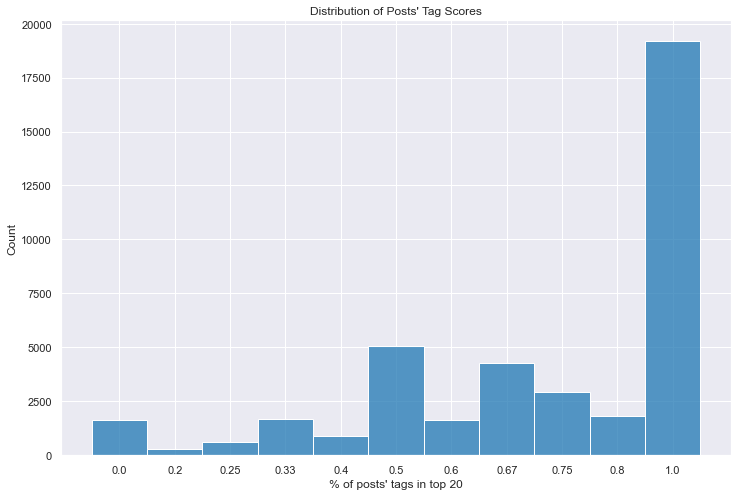

In [293]:
# Distribution of posts' top-20 prediction scores

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(x=sorted([str(round(x, 2)) for x in all_post_scores]))
ax.set_xlabel("% of posts' tags in top 20")
ax.set_title("Distribution of Posts' Tag Scores");

In [14]:
# Prep for more visualizations of results
# First, for top-20 score vs. number of tags in the post

q_test = q_clean[-40000:].copy()
q_test['n_tags'] = q_test['tags'].apply(len)

In [15]:
q_test['top20_score'] = all_post_scores

In [16]:
q_test[['tags','n_tags','top20_score']].groupby('n_tags').mean()

,top20_score
n_tags,
1,0.832158
2,0.797718
3,0.757161
4,0.714804
5,0.684480


In [17]:
q_test['top20_str'] = q_test['top20_score'].map(lambda x: round(x, 2)).map(str)

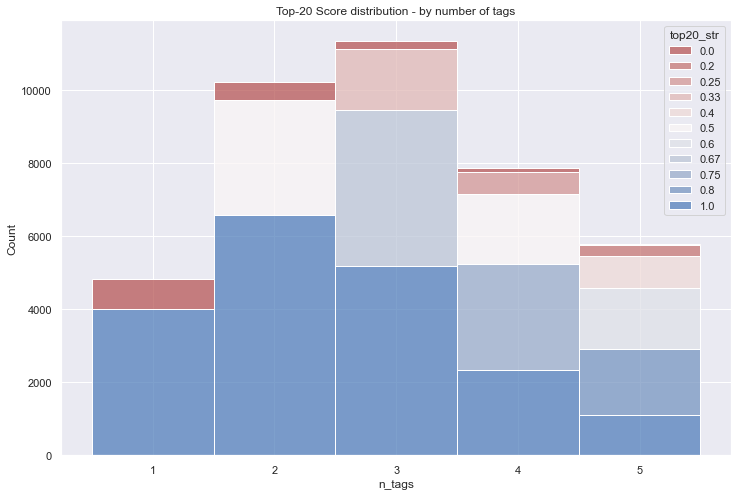

In [294]:
# Visualization of results - broken out by n_tags

fig, ax = plt.subplots(figsize=(12,8))

hue_order = sorted(q_test['top20_str'].unique(), reverse=False)
sns.histplot(data=q_test, x='n_tags', hue='top20_str', hue_order=hue_order,\
             palette='vlag_r', multiple='stack', discrete=True)

ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title('Top-20 Score distribution - by number of tags');

In [24]:
# prep for visualization of scores per tag, relating to their usage counts

all_tag_scores = top20_scores[5]

In [30]:
all_tags = list(all_tag_scores.keys())
tag_scores = [np.mean(all_tag_scores[x]) if x else 0 for x in all_tags]
tag_scores

[0.9772117962466488,
 0.8275862068965517,
 1.0,
 0.9523809523809523,
 0.9586267605633803,
 0.9324034334763949,
 0.9803240740740741,
 0.9710959454034525,
 0.9702380952380952,
 0.0,
 0.9831460674157303,
 0.6415094339622641,
 0.6052631578947368,
 0.9848484848484849,
 0.8541666666666666,
 0.9906542056074766,
 0.9562043795620438,
 0.9469320066334992,
 0.9594594594594594,
 0.0,
 0.9194029850746268,
 0.9615384615384616,
 0.464,
 0.0,
 0.8604651162790697,
 0.0,
 0.0,
 0.0,
 0.8636363636363636,
 0.75,
 0.0,
 0.9090909090909091,
 0.8387096774193549,
 0.2222222222222222,
 0.9890498057223596,
 0.0,
 0.0,
 0.0,
 0.8691588785046729,
 0.8571428571428571,
 0.0,
 0.9782065023222579,
 0.9473684210526315,
 0.3225806451612903,
 0.0,
 0.6842105263157895,
 0.8636363636363636,
 0.9821667409719126,
 0.9725792630676949,
 0.8962264150943396,
 0.8421052631578947,
 0.9135802469135802,
 0.9677790563866513,
 0.9733231707317073,
 0.9731182795698925,
 0.8918918918918919,
 0.75,
 0.0,
 0.9090909090909091,
 0.987380627

In [89]:
viz_df = pd.DataFrame()
viz_df['tag'] = all_tags
viz_df['score'] = tag_scores
viz_df['count'] = [len(t_test[t_test['Tag']==tag]) for tag in all_tags]
display(viz_df)

,tag,score,count
0,r,0.977212,746
1,geolocation,0.827586,29
2,raster,1.000000,3
3,plotly,0.952381,21
4,mysql,0.958627,1136
...,...,...,...
12145,treelist,0.000000,1
12146,kendo-treelist,0.000000,1
12147,remote-validation,0.000000,1
12148,gcc4.6,0.000000,1


In [90]:
viz_df = viz_df.sort_values(by='count', ascending=False)
viz_df = viz_df[['tag','score','count']]

In [288]:
# Second dataframe for calculating average score for >= n tag usage counts

viz_df2 = pd.DataFrame()
viz_df2['count'] = list(range(0,4500))
viz_df2['avg_score'] = [viz_df[viz_df['count']>=x]['score'].mean() for x in list(range(4500))]

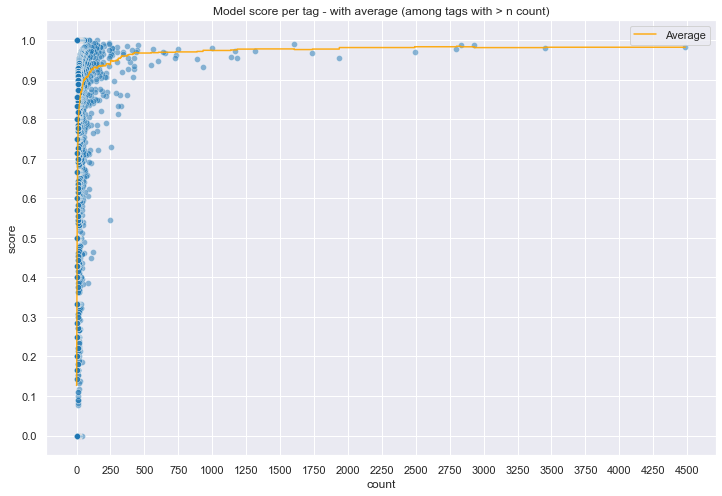

In [292]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=viz_df, x='count', y='score', alpha=.5)
sns.lineplot(data=viz_df2, x='count', y='avg_score', color='orange', alpha=.9, label='Average')
ax.set_xticks(list(range(0,4501,250)))
ax.set_yticks([x/10 for x in range(11)])
ax.set_title('Model score per tag - with average (among tags with > n count)')
plt.show()

This graph gives a look at the scores for each tag, plotted against that tag's count.

The orange line gives the average score for tags with >= that count.

This shows that the tags with at least 250 uses have > 80% top-20 prediction, and as you approach 0, the tags are pretty evenly spread across the score range.

---
Next, I'll graph the % of posts' tags that are NOT in the modelled tags.

In [21]:
bottom_tags = idtag_df.iloc[:-2000].tag.values

q_test['pct_bottom'] = q_test['tags'].apply(lambda x: [1 if y in bottom_tags else 0 for y in x])

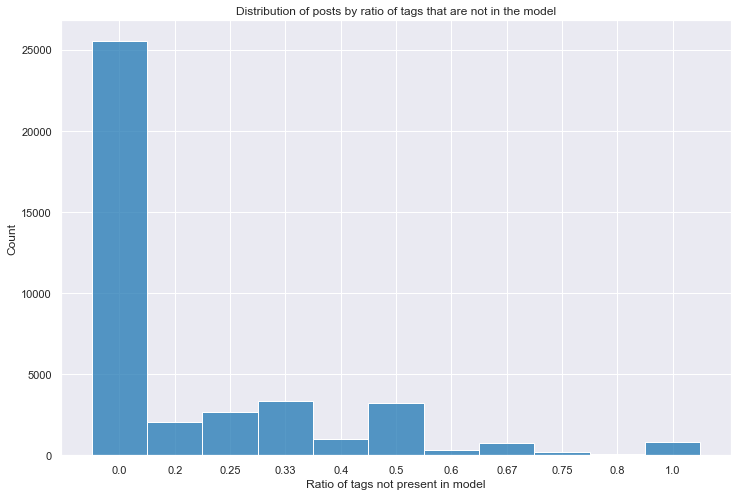

In [300]:
q_test['pct_bottom'] = q_test['pct_bottom'].apply(np.mean)

bottom_pcts = sorted([str(round(x,2)) for x in q_test['pct_bottom']])

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(x=bottom_pcts, stat='count')
ax.set_title('Distribution of posts by ratio of tags that are not in the model')
ax.set_xlabel('Ratio of tags not present in model');